Let's start with importing necessary libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import requests
import json
import tensorflow as tf
import unicodedata
import re
import os
# visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator
# sickit learning 
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier, VotingClassifier, BaggingClassifier
#from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
#from sklearn.manifold import TSNE
from sklearn.metrics import precision_score, classification_report, confusion_matrix
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, ShuffleSplit, RepeatedStratifiedKFold, KFold, cross_val_score
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC
# settings
#sns.color_palette("rocket_r", as_cmap=True)
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
np.random.seed(42)
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("../input/alldialectdataset/out.csv", encoding="utf-8", lineterminator='\n')
df.drop(columns=["id"], inplace=True)
df.columns = ['dialect', 'tweets']
df.dropna(inplace=True)

## `Clean Text` 
Next step to try several preprocessing methods **one at a time** to clean our tweets like:-

        * Select arabic characters only from text
        * Remove username "@handle" from text
        * Remove URL from text
        * Remove punctuation, emoji and smileys from text
        * Remove \n, \t ,,, etc from text
        * Remove Diacritization from text
        * Remove Arabic Stop Words from text
        
> Only  removing Diacritization and Escape Codes makes a slightly improvment in score.

In [3]:
from nltk.corpus import stopwords
nltk_stopwords = stopwords.words('arabic')
nltk_stopwords[:10]

['إذ', 'إذا', 'إذما', 'إذن', 'أف', 'أقل', 'أكثر', 'ألا', 'إلا', 'التي']

In [4]:
def remove_stop_words(text):
    words = [word for word in text.split() if word not in nltk_stopwords]
    return " ".join(words)    

> Preprocessing Pipeline

In [5]:
def clean_text(text):
    #text = ' '.join(re.findall(r'[\u0600-\u06FF]+', text)) # Select arabic characters only from text
    ###text = re.sub(r'(@.*?)[\s]', ' ', text) # Remove username "@handle"
    ##text = re.compile(r'https?://\S+|www\.\S+').sub(r'', text) # Remove username "@handle"
    ##text = re.sub(r'[^\w\s]', '', text) # Remove punctuation, emoji and smileys
    text = re.sub(r'\s+', ' ', text).strip()  # Remove Escape Codes
    text = re.sub(re.compile(r'[\u0617-\u061A\u064B-\u0652]'),"", text) # Remove Diacritizations
    #text = remove_stop_words(text)
    text = text.strip() 
    return text

df['clean_tweets'] = df.tweets.apply(lambda t: clean_text(t))

In [6]:
from sklearn.preprocessing import OneHotEncoder 
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['dialect_encode'] = le.fit_transform( df['dialect'] ).astype(np.int8)
target_names = le.inverse_transform(np.arange(18))
target_names

array(['AE', 'BH', 'DZ', 'EG', 'IQ', 'JO', 'KW', 'LB', 'LY', 'MA', 'OM',
       'PL', 'QA', 'SA', 'SD', 'SY', 'TN', 'YE'], dtype=object)

In [7]:
test_size = 0.20

![](https://miro.medium.com/max/1200/1*3-KkZ0hlRZxjMn7Z6uXDGg.png)

In [8]:
#X = df.tweets#clean_tweets#.values
X = df.clean_tweets.values
y = df.dialect_encode.values
y = np.array(y).reshape((-1,1)).ravel()

In [9]:
# The train val split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = test_size, shuffle=True, random_state = 42)

The shape of train dataset is 365757 and validation dataset is 91440.

In [10]:
X_train.shape, X_val.shape

((365757,), (91440,))

In [11]:
n_estimators = 10

In [12]:
def text_pipeline(clf):
    return Pipeline([
        ('vect', CountVectorizer()), # , tokenizer=clean_text
        ('tfidf', TfidfTransformer()),
        ('clf', OneVsRestClassifier(clf, n_jobs=-1))
    ])

In [13]:
clfs = {
    'LinearSVC': LinearSVC(),
    'LogisticRegression': LogisticRegression(C=5, solver='newton-cg', max_iter=1000, multi_class='ovr'),
    'SGDClassifier': SGDClassifier(loss='epsilon_insensitive', penalty='l2',alpha=0.0001, random_state=42), 
}

In [14]:
results = {}
for classifier_name, clf in clfs.items(): 
    text_clf  = text_pipeline(clf)
    text_clf.fit(X_train, y_train)
    predicted = text_clf.predict(X_val)
    # model accuracy: the total ratio of tp/(tp + fp)
    score = precision_score(predicted, y_val, average='micro') #np.mean(predicted == y_val)
    #print(classifier_name, score)
    
    results[classifier_name] = {
        "score" : score,
        "confusion_matrix": confusion_matrix(y_val, predicted),
        "classification_report": classification_report(
            predicted, 
            y_val,
            target_names = target_names, 
            digits=2,
            output_dict=True
        ),
    }

### Scores
`LinearSVC`
> 0.722

`Logistic Regression`
>  0.703

`SGD Classifier`
> 0.657

In [15]:
for classifier_name, clf in clfs.items(): 
    print(classifier_name, round(results[classifier_name]['score'], 3))

LinearSVC 0.722
LogisticRegression 0.703
SGDClassifier 0.657


`Confusion Matrix`

[None, None]

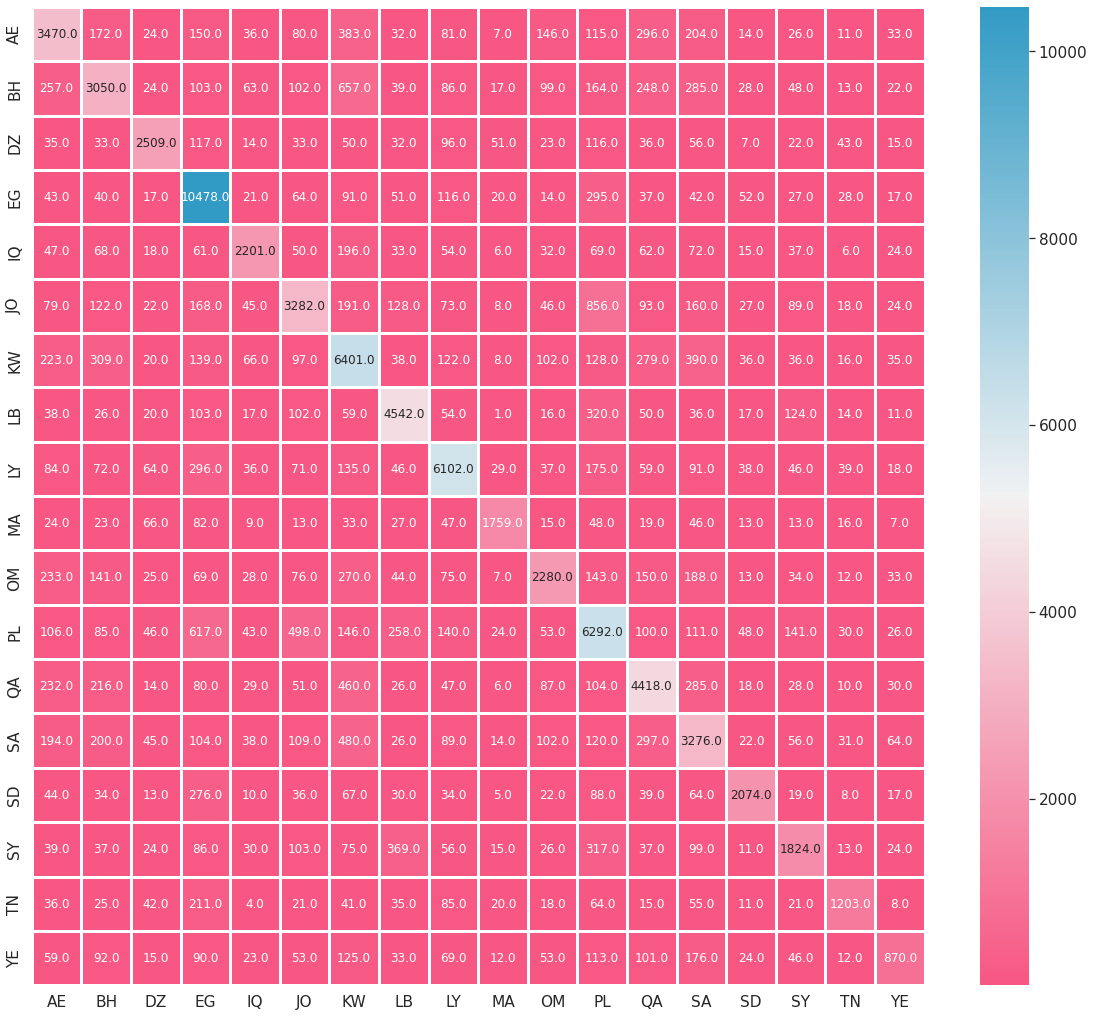

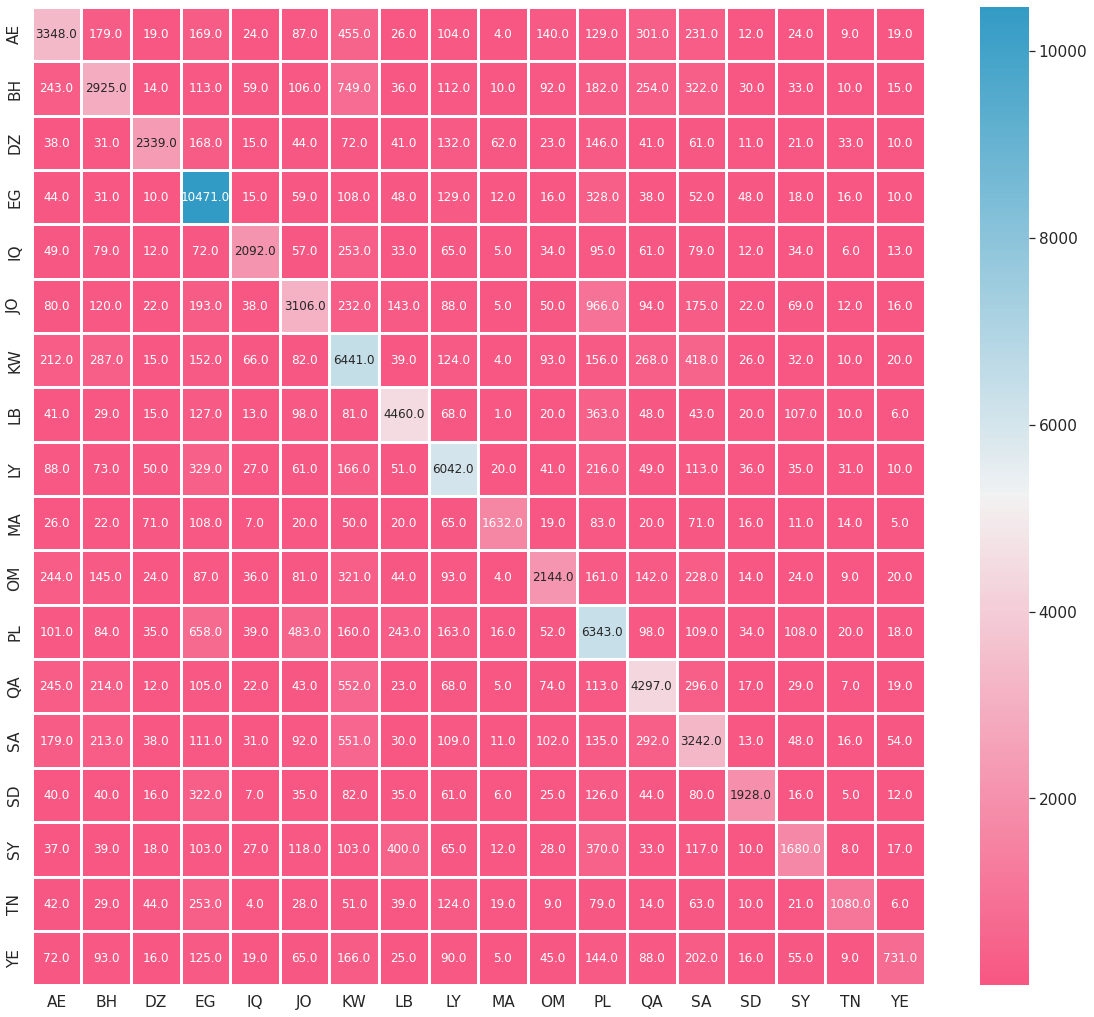

In [16]:
def ConfusionMatrix(cm):
    #cm = confusion_matrix(y_val, predicted)
    df_cm = pd.DataFrame(cm, target_names, target_names)

    plt.figure(figsize = (20, 18))
    sns.set(font_scale=1.4) # for label size
    sns.heatmap(
        df_cm,
        fmt=".1f", annot=True, annot_kws={'size': 12}, cmap=cmap,
        linewidths=3,
    );
    return None
    
display([
    ConfusionMatrix(results['LinearSVC']['confusion_matrix']), 
    ConfusionMatrix(results['LogisticRegression']['confusion_matrix']),
    #ConfusionMatrix(results['SGDClassifier']['confusion_matrix'])
])

## Notices from Confusion Matrix
Let's focus in high misclassification ratio happens for each dialect:- 

    - `AE` :  SA, KW, BH
    - `BH` :  AE, KW, OM, SA, QA
    - `DZ` :  MA, TN, LY
    - `EG` :  LY, PL, SD
    - `IQ` :  KW, BH
    - `JO` :  PL, LB, SY
    - `KW` :  BH, AE, QA, SA
    - `LB` :  PL, SY
    - `LY` :  EG, KW, PL, TN
    - `MA` :  DZ, LY
    - `OM` :  AE, BH, KW, QA, SA
    - `PL` :  JO, EG, LB, LY, SY
    - `QA` :  SA, KW, AE, BH
    - `SA` :  QA`, KW, BH, AE
    - `SD` :  EG, LY, PL
    - `SY` :  LB, PL
    - `TN` :  LY, DZ
    - `YE` :  SA
    
    
    
`Most of misclassifications happens for each dialect with dialects for share border countries. So we can make groups of share border countries like:-`

    - ['QA', 'SA', 'AE', 'KW', 'OM', 'YE','BH']
    - ['LY', 'SY', 'JO', 'PL', 'IQ']
    - ['EG', 'LY', 'SD']
    - ['TN', 'MA', 'DZ']

By breaking down accuracy scores to individual classes. If a model has higher accuracy scores for some classes than another model and vice versa we can use `Voting Classifier` to get a better overall accuracy. 

In [17]:
def breakdown_scores(matrix, pres):
    all_scores = pd.DataFrame()
    for i, matrix in enumerate(matrix):
        matrix = matrix.diagonal() / matrix.sum(axis=1)
        all_scores = pd.concat([
            all_scores, 
            pd.DataFrame({'Dialect': target_names, 'scores': matrix})
        ], axis=1)#.add_prefix(pres[i])
    return all_scores#.sort_values(by=['scores'], ascending=False)

In [18]:
breakdown_scores(
    [
        results['LinearSVC']['confusion_matrix'],
        results['LogisticRegression']['confusion_matrix'],
        #results['SGDClassifier']['confusion_matrix']
    ],
    ['svc_', 'log_'] #, 'sgd_'
    
)

,Dialect,scores,Dialect,scores
0,AE,0.657197,AE,0.634091
1,BH,0.574929,BH,0.551367
2,DZ,0.763078,DZ,0.711375
3,EG,0.914869,EG,0.914258
4,IQ,0.721403,IQ,0.685677
5,JO,0.604309,JO,0.571902
6,KW,0.757963,KW,0.762700
7,LB,0.818378,LB,0.803604
8,LY,0.820382,LY,0.812315
9,MA,0.778319,MA,0.722124


`Precision-Recall` is a useful measure of success of prediction when the classes are very imbalanced. 
In information retrieval, `precision` is a measure of result relevancy, while `recall` is a measure of how many truly relevant results are returned.

In [19]:
def Report(rp):
    report = pd.DataFrame(rp).T
    report['support'] = report.support.apply(int)
    return report
    
pd.concat([
    Report(results['LinearSVC']['classification_report']).add_prefix('svc_'),
    Report(results['LogisticRegression']['classification_report']).add_prefix('log_'), 
    #Report(results['SGDClassifier']['classification_report']).add_prefix('sgd_'),
], axis=1)

,svc_precision,svc_recall,svc_f1-score,svc_support,log_precision,log_recall,log_f1-score,log_support
AE,0.657197,0.661835,0.659508,5243,0.634091,0.652759,0.643289,5129
BH,0.574929,0.642782,0.606965,4745,0.551367,0.631340,0.588650,4633
DZ,0.763078,0.834109,0.797014,3008,0.711375,0.844404,0.772202,2770
EG,0.914869,0.791988,0.849005,13230,0.914258,0.766208,0.833712,13666
IQ,0.721403,0.811279,0.763706,2713,0.685677,0.823298,0.748212,2541
JO,0.604309,0.677959,0.639019,4841,0.571902,0.665809,0.615293,4665
KW,0.757963,0.649189,0.699372,9860,0.762700,0.608043,0.676647,10593
LB,0.818378,0.784591,0.801129,5789,0.803604,0.777545,0.790360,5736
LY,0.820382,0.821708,0.821044,7426,0.812315,0.784472,0.798151,7702
MA,0.778319,0.875560,0.824081,2009,0.722124,0.890344,0.797459,1833


![](https://miro.medium.com/max/1200/1*3-KkZ0hlRZxjMn7Z6uXDGg.png)

## OverSampling
By viewing the percentage of each dialect in the dataset is shows that it's imbalanced.
    - EG dialect has  balance a datase 12.6%
    - AE dialect has  balance a datase 5.74%
    - TN dialect has  balance a datase 12.5%

Trying to improve the performance of ML models we can use `Oversampling`.

`Oversampling` is a technique which increases the number of samples of the smallest class up to the size of the biggest class. This is done by generating synthetic samples.

In [20]:
#from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

X = TfidfVectorizer().fit_transform(df['clean_tweets'])
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = test_size, shuffle=True, random_state = 42)
X_train, y_train = RandomOverSampler(random_state=42).fit_resample(X_train, y_train)

OverSampler_results = {}
for classifier_name, text_clf in clfs.items(): 
    text_clf.fit(X_train, y_train)
    predicted = text_clf.predict(X_val)
    score = precision_score(predicted, y_val, average='micro')
    OverSampler_results[classifier_name] = {
        "score" : score,
        "confusion_matrix": confusion_matrix(y_val, predicted),
        "classification_report": classification_report(
            predicted, 
            y_val,
            target_names = target_names, 
            digits=2,
            output_dict=True
        ),
    }

### Scores after using OverSampling
`LinearSVC`
> 0.713

`logisticregresion`
> 0.707

`SGD Classifier`
>  0.642

In [21]:
for classifier_name, clf in clfs.items(): 
    print(classifier_name, round(OverSampler_results[classifier_name]['score'], 3))

LinearSVC 0.713
LogisticRegression 0.707
SGDClassifier 0.642


In [22]:
breakdown_scores(
    [
        OverSampler_results['LinearSVC']['confusion_matrix'],
        OverSampler_results['LogisticRegression']['confusion_matrix'],
        #OverSampler_results['SGDClassifier']['confusion_matrix']
    ],
    ['svc_', 'log_'] #, 'sgd_'
    
)

,Dialect,scores,Dialect,scores
0,AE,0.647727,AE,0.641856
1,BH,0.578699,BH,0.572479
2,DZ,0.766423,DZ,0.750912
3,EG,0.888239,EG,0.881167
4,IQ,0.735824,IQ,0.728614
5,JO,0.612963,JO,0.603940
6,KW,0.716755,KW,0.713795
7,LB,0.808468,LB,0.799459
8,LY,0.809088,LY,0.801425
9,MA,0.788053,MA,0.770796


### OverSampling makes an improvment to dailects with smaller amount texts like`YE`

![](https://miro.medium.com/max/1200/1*3-KkZ0hlRZxjMn7Z6uXDGg.png)

### A model for deployment

Unlike linearsvm, LogisticRegression has a pridect_prop function and since their accuracy scores are close, we choose
LogisticRegression model with multi_class parameter to 'ovr' which use One Vs Rest technique.

Let's starting with using TfidfVectorizer followed by oversampling method then training chosen model.

In [23]:
model = LogisticRegression(C=5, solver='newton-cg', max_iter=1000, multi_class='ovr')
model.fit(X_train, y_train)
predicted = text_clf.predict(X_val)

In [24]:
breakdown_scores([confusion_matrix(y_val, predicted)], pres=['']).sort_values(by=['scores'], ascending=False)

,Dialect,scores
7,LB,0.814595
9,MA,0.792920
4,IQ,0.774828
3,EG,0.772112
14,SD,0.740972
8,LY,0.729901
2,DZ,0.712591
16,TN,0.704439
12,QA,0.666667
10,OM,0.613190


![](https://miro.medium.com/max/1200/1*3-KkZ0hlRZxjMn7Z6uXDGg.png)

## `Save Model`
Using `pickle` package to save our trained model for local deployment.

In [25]:
import pickle

# save the model to disk
filename = 'model.sav'
pickle.dump(model, open(filename, 'wb'))